# Directory settings

In [116]:
# ! pip install -q pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [117]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = 'gs://ranzcr-data/'

from google.cloud import storage


client = storage.Client()
source_bucket_imagenes = client.get_bucket('ranzcr-data')

# CFG

In [118]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='resnet200d_320' # 
    size = 512
    scheduler='ReduceLROnPlateau' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs = 10
    factor=0.1 # ReduceLROnPlateau. 0.2
    patience=0 # ReduceLROnPlateau. 4
    eps=1e-6 # ReduceLROnPlateau
    T_max=5 # CosineAnnealingLR. 4
    T_0 = 4 # CosineAnnealingWarmRestarts
    lr= 5e-4 # 1e-4, 5e-4 para step 2
    min_lr= 1e-6
    batch_size= 24 # 24
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=666
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]. 
    train=True
    USE_TEST_FOLD = True
    CURRENT_FOLD = 0
    WARMUP = 10
    STEP = 0 # 0 sin annotaciones, 1, 2 y 3
    # step 2
    weights=[0.5, 1]
    teacher = '../input/resnet200d-step1-teachers/'
    # step 3
    student = '../input/resnet200-step2-students/'
    # MORE LAYERS: DenseSigmoid, BatchNorm y PReLU
    MORE_LAYERS_MODEL = False
    student_more_layers = '../input/resnet200dstudentsstep2/'
    # TODO para continuar entrenando
    CONTINUE_TRAINING = False
    continue_path = '../input/resnet200dstep3morelayersphase1/'
    lr_continue = 5e-5 # CAMBIAR A MANO
    # OTROS TIPOS DE MODELOS
    DO_EFFICIENT = False
    effnet_path = '../input/efficientnet-pytorch/'
    # SERESNET152D
    DO_SERESNET152D = False
    
# correciones
if CFG.debug:
    CFG.epochs = 1
    
if CFG.CONTINUE_TRAINING:
    CFG.epochs = 14
    CFG.lr = CFG.lr_continue
    
if CFG.MORE_LAYERS_MODEL:
    CFG.student = CFG.student_more_layers
    
if CFG.STEP == 3:
    CFG.USE_TEST_FOLD = True
    
if CFG.DO_SERESNET152D:
    CFG.model_name = 'seresnet152d_320'

In [119]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs
    
if CFG.DO_EFFICIENT:
    !pip install efficientnet_pytorch
    from efficientnet_pytorch import EfficientNet
    CFG.lr = 3e-3
    CFG.model_name = "efficientnet-b7"
    #CFG.size= 600
    CFG.epochs = 10 
    if CFG.device == 'GPU':
        CFG.batch_size = 8
    if CFG.device == 'TPU':
        CFG.batch_size = 16

In [120]:
pip install timm

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Library

In [121]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('gs://extras-entrenamiento/pytorch_image_models')
sys.path.append('gs://extras-entrenamiento/timm')

import os
import ast
import copy
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
# from warmup_scheduler import GradualWarmupScheduler

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import albumentations
from albumentations import *

import timm

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

1.7.0


# Utils

In [122]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Loading

In [123]:
train = pd.read_csv('gs://extras-entrenamiento/train_folds.csv')
dfx = pd.read_csv('gs://extras-entrenamiento/train_folds.csv')
train_annotations = pd.read_csv('gs://extras-entrenamiento/train_annotations.csv')

print("Folds are: ", sorted(dfx.fold.unique()))
print("Selected folds are: ", CFG.trn_fold)

Folds are:  [0, 1, 2, 3, 4]
Selected folds are:  [0]


# Dataset

In [124]:
# ====================================================
# Dataset
# ====================================================
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }


class TrainDataset(Dataset):
    def __init__(self, df, df_annotations, annot_size=50, transform=None, use_annot=False):
        self.df = df
        self.df_annotations = df_annotations
        self.use_annot = use_annot
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        self.shape = df.shape

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name + '.jpg'
#         image = cv2.imread(file_path)
        source_blob = source_bucket_imagenes.get_blob(file_path)
        image = np.asarray(bytearray(source_blob.download_as_string()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = torch.tensor(self.labels[idx]).float()
        # annotated imageç
        # STEP 1 o 2
        if CFG.STEP > 0 and CFG.STEP < 3:
            #STEP 2
            if CFG.STEP == 2 and self.use_annot:
                image_annot = image.copy()
            query_string = f"StudyInstanceUID == '{file_name}'"
            df = self.df_annotations.query(query_string)
            for i, row in df.iterrows():
                label = row["label"]
                data = np.array(ast.literal_eval(row["data"]))
                for d in data:
                    # STEP 2
                    if CFG.STEP == 2 and self.use_annot:
                        image_annot[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                                d[0]-self.annot_size//2:d[0]+self.annot_size//2,
                                :] = COLOR_MAP[label]
                    # STEP 1
                    else:
                        image[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                              d[0]-self.annot_size//2:d[0]+self.annot_size//2,
                              :] = COLOR_MAP[label]
        # aplicar transform
        if CFG.STEP == 2 and self.use_annot:
            if self.transform:
                augmented = self.transform(image=image, image_annot=image_annot)
                image = augmented['image']
                image_annot = augmented['image_annot']
            return image, image_annot, labels
        else:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, labels

# Transforms

In [125]:
# ====================================================
# Transforms
# ====================================================
# def get_transforms(*, data):
    
#     if data == 'train':
#         return Compose([
#            albumentations.RandomResizedCrop(CFG.size, CFG.size, scale=(0.9, 1), p=1), 
#            albumentations.HorizontalFlip(p=0.5),
#            albumentations.ShiftScaleRotate(p=0.5),
#            albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
#            albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
#            albumentations.CLAHE(clip_limit=(1,4), p=0.5),
#            albumentations.OneOf([
#                albumentations.OpticalDistortion(distort_limit=1.0),
#                albumentations.GridDistortion(num_steps=5, distort_limit=1.),
#                albumentations.ElasticTransform(alpha=3),
#            ], p=0.2),
#            albumentations.OneOf([
#                albumentations.GaussNoise(var_limit=[10, 50]),
#                albumentations.GaussianBlur(),
#                albumentations.MotionBlur(),
#                albumentations.MedianBlur(),
#            ], p=0.2),
#           albumentations.Resize(CFG.size, CFG.size),
#           albumentations.OneOf([
#               JpegCompression(),
#               Downscale(scale_min=0.1, scale_max=0.15),
#           ], p=0.2),
#           IAAPiecewiseAffine(p=0.2),
#           IAASharpen(p=0.2),
#           albumentations.Cutout(max_h_size=int(CFG.size * 0.1), max_w_size=int(CFG.size * 0.1), num_holes=5, p=0.5),
#           albumentations.Normalize(),
#         ToTensorV2(),
#         ])

#     elif data == 'valid':
#         return Compose([
#             albumentations.Resize(CFG.size, CFG.size),
#            albumentations.Normalize(),
#         ToTensorV2(),
#         ])
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
def get_transforms_step2(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ], additional_targets={'image_annot': 'image'})
    
    elif data == 'check':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            ToTensorV2(),
        ], additional_targets={'image_annot': 'image'})

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

(30083, 15)


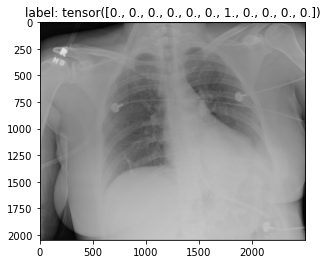

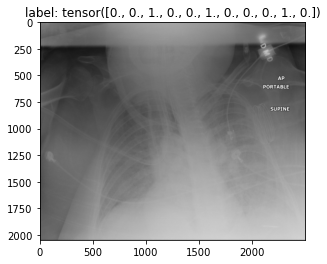

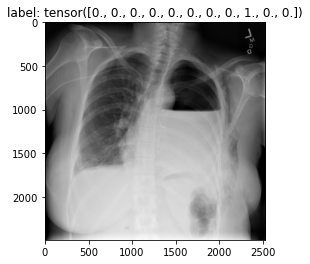

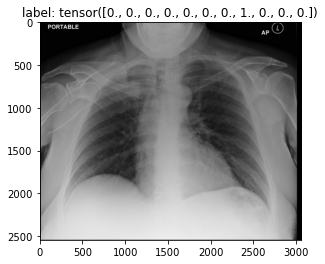

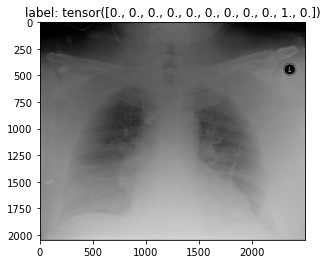

In [126]:
from matplotlib import pyplot as plt


# annotated
if CFG.STEP == 1:
    train_dataset = TrainDataset(dfx[dfx['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                             df_annotations = train_annotations, transform = None)
elif CFG.STEP == 2:
    train_dataset = TrainDataset(dfx[dfx['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                             df_annotations = train_annotations, transform=get_transforms_step2(data='check'), use_annot=True)
else:
    train_dataset = TrainDataset(dfx, df_annotations = train_annotations, transform=None)
    
print(train_dataset.shape)

for i in range(5):
    if CFG.STEP == 2:
        image, image_annot, label = train_dataset[i]
        plt.subplot(1, 2, 1)
        plt.imshow(image.transpose(0, 1).transpose(1, 2))
        plt.subplot(1, 2, 2)
        plt.imshow(image_annot.transpose(0, 1).transpose(1, 2))
        plt.title(f'label: {label}')
        plt.show() 
    else:
        image, label = train_dataset[i]
        plt.imshow(image)
        plt.title(f'label: {label}')
        plt.show() 

In [127]:

# source_blob = source_bucket_imagenes.get_blob('1.2.826.0.1.3680043.8.498.10001065121843652267743449160233082683.jpg')
# image = np.asarray(bytearray(source_blob.download_as_string()), dtype="uint8")
# image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# # image = cv2.imread('gs://ranzcr-data/1.2.826.0.1.3680043.8.498.10001065121843652267743449160233082683.jpg')
# # image = io.imread('https://storage.cloud.google.com/ranzcr-data/1.2.826.0.1.3680043.8.498.10001065121843652267743449160233082683.jpg?authuser=1')
# plt.imshow(image, cmap='gray')

# MODEL

In [128]:
# ====================================================
# MODEL RESNET 200D
# ====================================================
class CustomResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        if pretrained:
            pretrained_path = 'gs://extras-entrenamiento/resnet200d_ra2-bdba9bf9.pth'
#             self.model.load_state_dict(torch.load(pretrained_path))
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features # son 2048
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        if CFG.MORE_LAYERS_MODEL:
            self.sigmoid_fc = nn.Linear(in_features=n_features, out_features=512)
            self.bs = nn.BatchNorm1d(num_features = 512)
            self.prelu = nn.PReLU()
            self.fc = nn.Linear(512, CFG.target_size)
        else:
            self.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        if CFG.MORE_LAYERS_MODEL:
            output = F.sigmoid(self.sigmoid_fc(pooled_features))
            output = self.bs(output)
            output = self.prelu(output)
            output = self.fc(output) #output pooled_features
        else:
            output = self.fc(pooled_features)
        # features, _, y_preds
        return features, pooled_features, output
    
    
# ====================================================
# MODEL EFFICIENT B7
# ====================================================
class CustomEfficientB7(nn.Module):
    def __init__(self, model_name='efficientnet-b7', pretrained=False):
        super().__init__()
        self.effnet = EfficientNet.from_pretrained(model_name) 
        n_features = self.effnet._fc.in_features
#         self.effnet._conv_stem.in_channels = 1
#         weight = self.effnet._conv_stem.weight.mean(1, keepdim=True)
#         self.effnet._conv_stem.weight = torch.nn.Parameter(weight)
        self.effnet._fc = nn.Identity()
        
        if CFG.MORE_LAYERS_MODEL:
            self.sigmoid_fc = nn.Linear(in_features=n_features, out_features=512)
            self.bs = nn.BatchNorm1d(num_features = 512)
            self.prelu = nn.PReLU()
            self.out = nn.Linear(512, CFG.target_size)
        else:
            self.out = nn.Linear(n_features, CFG.target_size)

    def forward(self, image):
        batch_size = image.size(0)
    
        x = self.effnet.extract_features(image)
        pooled_features = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        if CFG.MORE_LAYERS_MODEL:
            output = F.sigmoid(self.sigmoid_fc(pooled_features))
            output = self.bs(output)
            output = self.prelu(output)
            output = self.out(output)
        else:
            output = self.out(pooled_features)
        # features, _, y_preds
        return x, pooled_features, output

Funcion Loss para step 2
---

In [129]:
class CustomLoss(nn.Module):
    def __init__(self, weights=[1, 1]):
        super(CustomLoss, self).__init__()
        self.weights = weights
        
    def forward(self, teacher_features, features, y_pred, labels):
        consistency_loss = nn.MSELoss()(teacher_features.view(-1), features.view(-1))
        cls_loss = nn.BCEWithLogitsLoss()(y_pred, labels)
        loss = self.weights[0] * consistency_loss + self.weights[1] * cls_loss
        return loss

# Helper functions

In [130]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))
# https://www.kaggle.com/underwearfitting/single-fold-training-of-resnet200d-lb0-965
# class GradualWarmupSchedulerV2(GradualWarmupScheduler):
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
#         super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
#     def get_lr(self):
#         if self.last_epoch > self.total_epoch:
#             if self.after_scheduler:
#                 if not self.finished:
#                     self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
#                     self.finished = True
#                 return self.after_scheduler.get_lr()
#             return [base_lr * self.multiplier for base_lr in self.base_lrs]
#         if self.multiplier == 1.0:
#             return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
#         else:
#             return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
#                       'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
#                        lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
#                                 'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
#                                 lr=scheduler.get_lr()[0],
                                ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

In [131]:
# ****************************************************************************************************
# **************************************** FOR STEP 2 ************************************************
# ****************************************************************************************************
def train_fn_step2(train_loader, teacher_model, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, images_annot, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        with torch.no_grad():
            teacher_features, _, _ = teacher_model(images_annot.to(device))
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                features, _, y_preds = model(images)
                loss = criterion(teacher_features, features, y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            features, _, y_preds = model(images)
            loss = criterion(teacher_features, features, y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True) # 
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                lr=scheduler.get_lr()[0],
                                ))
    return losses.avg


# Train loop

In [132]:
# ====================================================
# Train loop
# ====================================================
def train_loop(fold):

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")
    elif CFG.device == 'TPU':
        if CFG.nprocs == 1:
            LOGGER.info(f"========== fold: {fold} training ==========")
        elif CFG.nprocs == 8:
            xm.master_print(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = dfx[dfx['fold'] != fold].index
    val_idx = dfx[dfx['fold'] == fold].index

    train_folds = dfx.loc[trn_idx].reset_index(drop=True)
    valid_folds = dfx.loc[val_idx].reset_index(drop=True)
    
    print(train_folds.shape)
    print(valid_folds.shape)
    
    # para anotaciones
    if CFG.STEP == 1 or CFG.STEP == 2:
        train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        if CFG.STEP == 1:
            valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
        print(train_folds.shape)
        print(valid_folds.shape)

    # Para validar y asignar pesos de los modelos
    if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
        test_fold = 0
        train_folds = train_folds[train_folds.fold_test != test_fold].reset_index(drop=True)
        valid_folds = valid_folds[valid_folds.fold_test != test_fold].reset_index(drop=True)
        test_fold = dfx.loc[dfx['fold_test'] == test_fold].reset_index(drop=True)
        print(train_folds.shape)
        print(valid_folds.shape)
        print(test_fold.shape)
    
    valid_labels = valid_folds[CFG.target_cols].values

    if CFG.STEP == 2:
        use_annotations = True
        transform_function_to_use_Train = get_transforms_step2(data='train')
        transform_function_to_use_Valid = get_transforms_step2(data='valid')
    else:
        use_annotations = False
        transform_function_to_use_Train = get_transforms(data='train')
        transform_function_to_use_Valid = get_transforms(data='valid')
        
    train_dataset = TrainDataset(train_folds, df_annotations = train_annotations, use_annot = use_annotations,
                                 transform = transform_function_to_use_Train)
    valid_dataset = TrainDataset(valid_folds, df_annotations = train_annotations, use_annot = False,
                                 transform = transform_function_to_use_Valid)
    if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
        test_fold_dataset = TrainDataset(test_fold, df_annotations = train_annotations,
                                     transform=get_transforms(data='valid'))

    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, 
                                  batch_size=CFG.batch_size, 
                                  shuffle=True, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size=CFG.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
        if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
            test_fold_loader = DataLoader(test_fold_dataset, 
                                      batch_size=CFG.batch_size * 2, 
                                      shuffle=False, 
                                      num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=CFG.batch_size,
                                                   sampler=train_sampler,
                                                   drop_last=True,
                                                   num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size=CFG.batch_size * 2,
                                                   sampler=valid_sampler,
                                                   drop_last=False,
                                                   num_workers=CFG.num_workers)
        if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
            test_fold_sampler = torch.utils.data.distributed.DistributedSampler(test_fold_dataset,
                                                                            num_replicas=xm.xrt_world_size(),
                                                                            rank=xm.get_ordinal(),
                                                                            shuffle=False)
            test_fold_loader = torch.utils.data.DataLoader(test_fold_dataset,
                                                       batch_size=CFG.batch_size * 2,
                                                       sampler=test_fold_sampler,
                                                       drop_last=False,
                                                       num_workers=CFG.num_workers)


    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
    elif CFG.device == 'GPU':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
       
    # Leemos el modelo del STEP 1 
    if CFG.STEP == 2:
        teacher_model = CustomResNet200D(CFG.model_name, pretrained=False)
        teacher_model_path = CFG.teacher + "resnet200d_320_fold" + str(fold) + "_step1_best_loss_cpu.pth"
        teacher_model.load_state_dict(torch.load(teacher_model_path, map_location=torch.device('cpu'))['model'])
        for param in teacher_model.parameters():
            param.requires_grad = False
        teacher_model.eval()
        teacher_model.to(device)
        
    # Elegimos el tipo de modelo a entrenar
    if CFG.DO_EFFICIENT:
        model = CustomEfficientB7(CFG.model_name, pretrained=True)
    else:
        model = CustomResNet200D(CFG.model_name, pretrained=True)
        
    # Leemos estudiante si STEP es 3
    if CFG.STEP == 3 and CFG.CONTINUE_TRAINING == False:
        student_model_path = CFG.student + "resnet200d_320_fold" + str(fold) + "_step2_best_loss.pth"
        model.load_state_dict(torch.load(student_model_path, map_location=torch.device('cpu'))['model'])
        
    # Continuacion de entrenamiento
    if CFG.STEP == 3 and CFG.CONTINUE_TRAINING:
        continue_model_path = CFG.continue_path + "resnet200d_320_fold" + str(fold) + "_step3_best_loss_cpu.pth"
        model.load_state_dict(torch.load(continue_model_path, map_location=torch.device('cpu'))['model'])
        
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
#     warmup_epo = 1 #++
#     scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler = scheduler) #++

    # ====================================================
    # loop
    # ====================================================
    if CFG.STEP == 2:
        train_criterion = CustomLoss(weights=CFG.weights)
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
#         scheduler_warmup.step(epoch) # ++ 
        
        # ********* train *********
        #  ********* TPU *********
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                if CFG.STEP == 2:
                    avg_loss = train_fn_step2(train_loader, teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
                else:
                    avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                if CFG.STEP == 2:
                    avg_loss = train_fn_step2(para_train_loader.per_device_loader(device), teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
                else:
                    avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        #  ********* GPU *********
        elif CFG.device == 'GPU':
            if CFG.STEP == 2:
                avg_loss = train_fn_step2(train_loader, teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
            else:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                
        # ********* eval *********
        if CFG.device == 'TPU' and CFG.nprocs == 8: # TODO test_fold
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else: # para TPU (1 proc) y GPU
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
                test_fold_avg_val_loss, test_fold_preds, _ = valid_fn(test_fold_loader, model, criterion, device)
            
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # ********* scoring *********
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
                LOGGER.info(f'Epoch {epoch+1} - test_fold_avg_val_loss: {test_fold_avg_val_loss:.4f}')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
                    LOGGER.info(f'Epoch {epoch+1} - test_fold_avg_val_loss: {test_fold_avg_val_loss:.4f}')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                if CFG.USE_TEST_FOLD and (CFG.STEP == 0 or CFG.STEP == 3):
                    xm.master_print(f'Epoch {epoch+1} - test_fold_avg_val_loss: {test_fold_avg_val_loss:.4f}')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        # ********************
         # SAVE MAX SCORE
        # ********************
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_score.pth')
         # ********************
         # SAVE MIN LOSS
        # ********************
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_loss.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_loss.pth')
    
    if CFG.nprocs != 8:
        check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_score.pth')
        for c in [f'pred_{c}' for c in CFG.target_cols]:
            valid_folds[c] = np.nan
        valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [133]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [134]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        print('TPU MODE')
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        print('GPU MODE')
        main()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========


GPU MODE
(24080, 15)
(6003, 15)
(23091, 15)
(5747, 15)
(1245, 15)
load resnet200d_320 pretrained model


SSLError: Caught SSLError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/opt/conda/lib/python3.7/http/client.py", line 1369, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.7/http/client.py", line 310, in begin
    version, status, reason = self._read_status()
  File "/opt/conda/lib/python3.7/http/client.py", line 271, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/opt/conda/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.7/ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "/opt/conda/lib/python3.7/ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)
ssl.SSLError: [SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:2570)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/requests/adapters.py", line 449, in send
    timeout=timeout
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 756, in urlopen
    method, url, error=e, _pool=self, _stacktrace=sys.exc_info()[2]
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/retry.py", line 573, in increment
    raise MaxRetryError(_pool, url, error or ResponseError(cause))
urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='storage.googleapis.com', port=443): Max retries exceeded with url: /storage/v1/b/ranzcr-data/o/1.2.826.0.1.3680043.8.498.12656060570659327414071698292992569998.jpg?projection=noAcl (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:2570)')))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-124-f6536a595594>", line 36, in __getitem__
    source_blob = source_bucket_imagenes.get_blob(file_path)
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/storage/bucket.py", line 1044, in get_blob
    if_metageneration_not_match=if_metageneration_not_match,
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/storage/_helpers.py", line 207, in reload
    timeout=timeout,
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/_http.py", line 419, in api_request
    timeout=timeout,
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/_http.py", line 277, in _make_request
    method, url, headers, data, target_object, timeout=timeout
  File "/opt/conda/lib/python3.7/site-packages/google/cloud/_http.py", line 315, in _do_request
    url=url, method=method, headers=headers, data=data, timeout=timeout
  File "/opt/conda/lib/python3.7/site-packages/google/auth/transport/requests.py", line 470, in request
    **kwargs
  File "/opt/conda/lib/python3.7/site-packages/requests/sessions.py", line 542, in request
    resp = self.send(prep, **send_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/requests/sessions.py", line 655, in send
    r = adapter.send(request, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/requests/adapters.py", line 514, in send
    raise SSLError(e, request=request)
requests.exceptions.SSLError: HTTPSConnectionPool(host='storage.googleapis.com', port=443): Max retries exceeded with url: /storage/v1/b/ranzcr-data/o/1.2.826.0.1.3680043.8.498.12656060570659327414071698292992569998.jpg?projection=noAcl (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:2570)')))


In [ ]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            # best score
            state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_score.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 
                        'preds': state['preds']}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_score_cpu.pth')
            # best loss
            state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_loss.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 
                        'preds': state['preds']}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_step{CFG.STEP}_best_loss_cpu.pth')

In [ ]:
# model = timm.create_model('resnet200d_320', pretrained=True)
# pretrained_path = 'https://storage.cloud.google.com/extras-entrenamiento/resnet200d_ra2-bdba9bf9.pth?authuser=1'
# model.load_state_dict(torch.load(pretrained_path))